The streams were created by generating mock streams around progenitor (globular cluster) orbits sampled from a spherical, isotropic distribution function (see PDF paper draft for more details). The cluster masses (which sets the velocity dispersion, scale of the Lagrange points) are sampled from a power-law distribution with slope -2 between $10^4$ and $10^7~{\rm M}_\odot$. The background gravitational potential is smooth, but grows with time (cosmologically-motivated) -- see plots in the attached PDF. The stream particles have different masses.

The streams were saved in an HDF5 file, so I'll show you how to read them.

In [39]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import h5py
import matplotlib as mpl
# Custom
import gala.coordinates as gc
import gala.dynamics as gd

The top-level of the file contains 2 groups:

In [2]:
f = h5py.File('sph_iso.hdf5')
print(list(f.keys()))

['progenitors', 'streams']


The `'progenitors'` group contains information about the globular clusters themselves, like the initial cluster masses, and the orbital initial conditions:

In [3]:
print(list(f['progenitors/initial'].keys()))

['mass', 'pos', 'vel']


In [63]:
initial_radius = np.sum(f['progenitors/initial']['pos'].value**2., axis=0)
initial_velocity = np.sum(f['progenitors/initial']['vel'].value**2., axis=0)

Text(0.5,1,'initial radius')

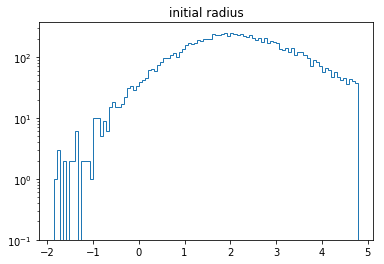

In [33]:
plt.hist(np.log10(initial_radius), bins=100, log=True, histtype='step')
plt.title('initial radius')

Text(0.5,1,'initial velocity')

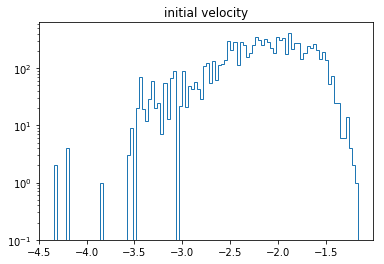

In [64]:
plt.hist(np.log10(initial_velocity), bins=100, log=True, histtype='step')
plt.title('initial velocity')

Text(0.5,1,'progenitor masses')

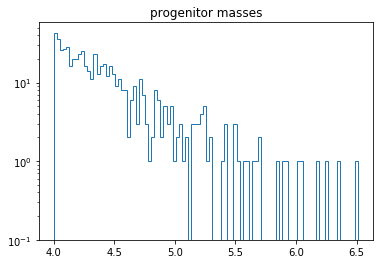

In [34]:
plt.hist(np.log10(f['progenitors/initial/mass'].value[initial_radius > 1e4]), bins=100, log=True, histtype='step')
plt.title('progenitor masses')

Text(0,0.5,'log Radius')

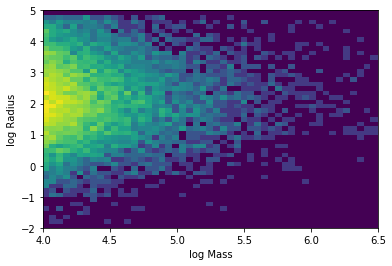

In [42]:
nbins = 50
xbins = np.linspace(4, 6.5, nbins)
ybins = np.linspace(-2, 5, nbins)
H, xe, ye = np.histogram2d(np.log10(f['progenitors/initial/mass'].value), np.log10(initial_radius), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Mass')
plt.ylabel('log Radius')

In [81]:
np.where(f['progenitors/initial/mass'].value == np.min(f['progenitors/initial/mass'].value[~np.isnan(tdisrupt) & 
                                                                                           (initial_velocity > 1e-2) & 
                                                                                          (initial_radius > 1e4)]))

(array([6953]),)

-10797.215936008448


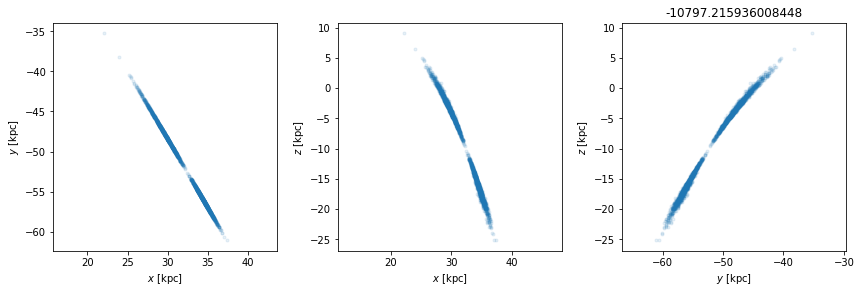

In [78]:
ind = 'streams/2911'
f[ind]['pos'].value
w = gd.PhaseSpacePosition.from_hdf5(f[ind])
_ = w.plot(alpha=0.1, marker='.')
plt.title(f[ind + '/t_disrupt'].value)
print(f[ind + '/t_disrupt'].value)

In [94]:
print(list(f[ind + '/final'].keys()))
print(list(f[ind].keys()))

['mass', 'pos', 'vel']
['final', 'pos', 't_disrupt', 'vel', 'weights']


In [102]:
probabilities = f[ind+'/weights'].value/np.sum(f[ind+'/weights'].value)

In [133]:
streamMass = np.sum(f['streams/2911/weights'].value)

In [134]:
print(streamMass)

10013.745192694765


In [117]:
len(probabilities)

2396

In [119]:
n = len(probabilities)
ind = np.random.choice(n, size=50, replace=False, p=probabilities)

In [121]:
import imf

In [122]:
k01 = imf.Kroupa2001()

In [139]:
np.sum(k01.random(25000))

10052.376308782941

In [142]:
np.min(k01.random(25000))

0.010004125460013575

In [120]:
ind

array([ 477, 2179, 1617,  657,  635,  678, 2153, 1134,  612,  544,   62,
       2293,  919,  858, 1007,  445, 2315, 1802,  648,  246, 1127,  968,
       1349,  397, 1570, 1309, 2076,  894,  623, 1867,  889, 1930, 2064,
        278,  444, 1308, 1209, 2355, 1205,  240,  940,  567,  701,  960,
       1218, 1241, 1333,  921, 1086, 1018])

In [114]:
val = 2911
for val in np.random.randint(0, 10000, 10):

    print(f['progenitors/initial/mass'][val])
    print(f['streams/' + str(val) + '/final/mass'].value)
    print(np.sum(f['streams/'+ str(val) + '/weights'].value))

50184.57252724906
0.0
50183.572527217024
24873.421039797875
0.0
24872.421039782042
10200.579421568173
0.0
10199.579421561679
43544.8452993347
0.0
43543.84529930743
12445.419200227932
0.0
12444.419200220007
31786.906962556215
0.0
31785.906962535882
501214.4331979524
250743.76967813532
250499.4750569153
13145.279760837599
0.0
13144.279760829228
20693.299507287345
0.0
20692.29950727413
11565.026545769304
0.0
11564.026545761939


In [19]:
f['streams/2902']['pos'].value

array([[ 0.62658253,  0.13200334, -0.21372395, ..., -0.47092716,
         0.78619744,  0.43757884],
       [ 0.17868591,  0.43530476,  0.51307183, ..., -0.01173761,
         0.17050125,  0.20686204],
       [-0.08481472,  0.41048723, -0.32720698, ..., -0.09317055,
         0.00228719,  0.02376774]])

In [4]:
print(list(f['streams'].keys()))

['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '1060', '1061', '1062', '1063', '1064', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '1090', '1091', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '1110', '1111', '1112', '1113', '1114', '1115', '1116', '1117', '1118', '1119', '

There are 10000 clusters initially, so the `mass`, `pos`, and `vel` datasets in the HDF5 file are all length 10000 (but pos and vel are (3, 10000) for the 3D cartesian positions):

In [5]:
print(f['progenitors/initial/mass'].shape,
      f['progenitors/initial/pos'].shape,
      f['progenitors/initial/vel'].shape)

(10000,) (3, 10000) (3, 10000)


But I don't think you care about those. I think you just want the streams particles! Those are in the other top-level dataset, and each of the 10000 streams are indexed (0–9999) after this group. So, for example, to get the stream particle information for stream number 371:

In [5]:
stream_info = f['streams/3']
print(list(stream_info.keys()))

['final', 'pos', 't_disrupt', 'vel', 'weights']


In [6]:
tdisrupt = []
for i in range(10000):
    try:
        tdisr = f['streams/{0}/t_disrupt'.format(i)].value
        tdisrupt.append(tdisr)
    except KeyError:
        tdisrupt.append(np.NaN)


In [52]:
tdisrupt = np.array(tdisrupt)

10000
[5343 8432 4701 ... 8892  749 8483]


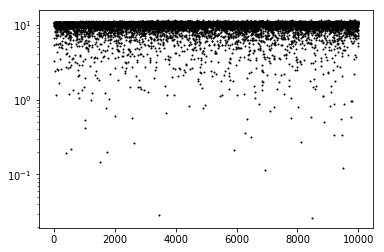

In [7]:
plt.plot(np.abs(np.array(tdisrupt)/1000.), 'ko', markersize=1)
plt.yscale('log')
print(len(tdisrupt))
print(np.argsort(np.array(tdisrupt)))

The per-stream groups also contain `pos` and `vel`, which are 3D cartesian position/velocity, but now these are the individual stream particle positions/velocities, so the number varies depending on the time at which the progenitor fully disrupts:

In [53]:
tdisrupt[~np.isnan(tdisrupt)]

array([-10290.24096318,  -3282.89403863,  -9614.0373178 , ...,
        -5138.01003316, -10329.34842953, -10773.04041136])

(array([2.000e+00, 0.000e+00, 3.000e+00, 6.000e+00, 8.000e+00, 2.100e+01,
        5.600e+01, 1.240e+02, 4.360e+02, 8.666e+03]),
 array([1.42009871, 1.68397462, 1.94785052, 2.21172642, 2.47560232,
        2.73947822, 3.00335412, 3.26723002, 3.53110592, 3.79498182,
        4.05885772]),
 <a list of 10 Patch objects>)

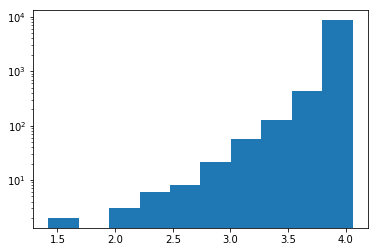

In [55]:
plt.hist(np.log10(np.abs(tdisrupt[~np.isnan(tdisrupt)])), log= True)

Text(0,0.5,'log Radius')

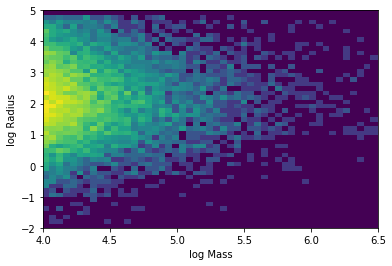

In [43]:
nbins = 50
xbins = np.linspace(4, 6.5, nbins)
ybins = np.linspace(-2, 5, nbins)
H, xe, ye = np.histogram2d(np.log10(f['progenitors/initial/mass'].value), np.log10(initial_radius), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Mass')
plt.ylabel('log Radius')

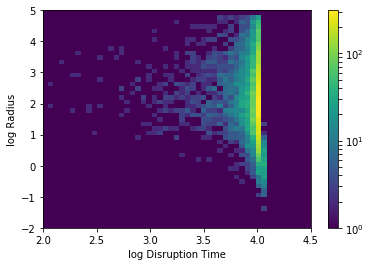

In [62]:
nbins = 50
xbins = np.linspace(2, 4.5, nbins)
ybins = np.linspace(-2, 5, nbins)
H, xe, ye = np.histogram2d(np.log10(np.abs(tdisrupt[~np.isnan(tdisrupt)])), np.log10(initial_radius[~np.isnan(tdisrupt)]), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Disruption Time')
plt.ylabel('log Radius')
plt.colorbar()

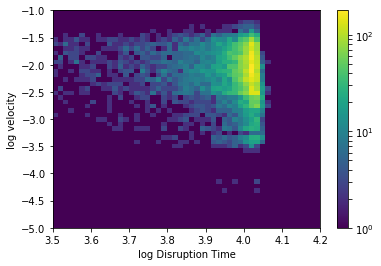

In [69]:
nbins = 50
xbins = np.linspace(3.5, 4.2, nbins)
ybins = np.linspace(-5, -1, nbins)
H, xe, ye = np.histogram2d(np.log10(np.abs(tdisrupt[~np.isnan(tdisrupt)])), np.log10(initial_velocity[~np.isnan(tdisrupt)]), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Disruption Time')
plt.ylabel('log velocity')
plt.colorbar()

In [9]:
stream_info['pos'].shape

(3, 5724)

The time of full disruption is in `'t_disrupt'`, and it's stored as a scalar dataset in units of Myr (0 is z=0):

In [10]:
stream_info['t_disrupt'].value * u.Myr

<Quantity -9614.0373178 Myr>

To make a spherically-averaged mass profile of all of the stream stars, we have to loop over stream index. Rather than loading all data into memory, here we bin each individual stream in spherical radius and then coadd the binned values:

In [11]:
bins = np.logspace(-1., np.log10(300), 33) # 0.1 to 300 kpc
all_H = np.zeros(bins.size-1)

count = 0
for key in f['streams']:
    i = int(key)
    if i % 1000 == 0 and i > 0:
        print(key)

    count += 1
    pos = f['streams'][key]['pos'][:]
    if pos.shape[1] > 0:
        r = np.sqrt(np.sum(pos**2, axis=0))
        w = f['streams'][key]['weights'][:]
        H, _ = np.histogram(r, bins=bins, weights=w)
        all_H += H

V = 4/3*np.pi*(bins[1:]**3 - bins[:-1]**3)
bin_cen = (bins[1:]+bins[:-1])/2.

1000
2000
3000
4000
5000
6000
7000
8000
9000


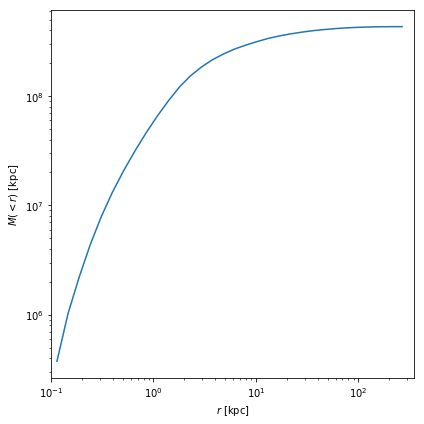

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.loglog(bin_cen, np.cumsum(all_H), ls='-', marker='', lw=1.5)

ax.set_xlim(0.1, 350)
ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel(r'$M(<r)$ [kpc]')

fig.tight_layout()

With `gala`, you can load the streams in as phase-space position objects, which we can use to easily plot or convert to observable coordinates:

-10797.215936008448


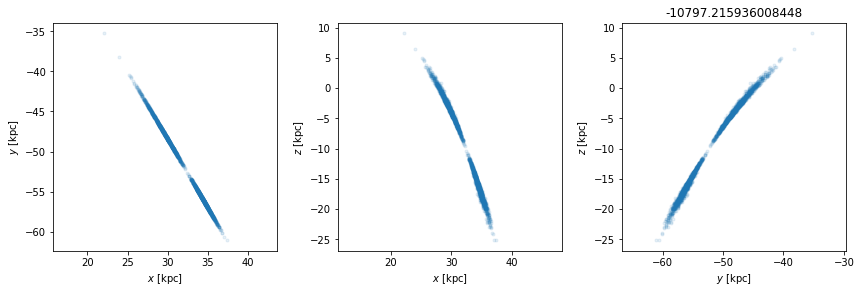

In [36]:
f['streams/2902']['pos'].value
w = gd.PhaseSpacePosition.from_hdf5(f['streams/2911'])
_ = w.plot(alpha=0.1, marker='.')
plt.title(f['streams/2911/t_disrupt'].value)
print(f['streams/2911/t_disrupt'].value)

nan


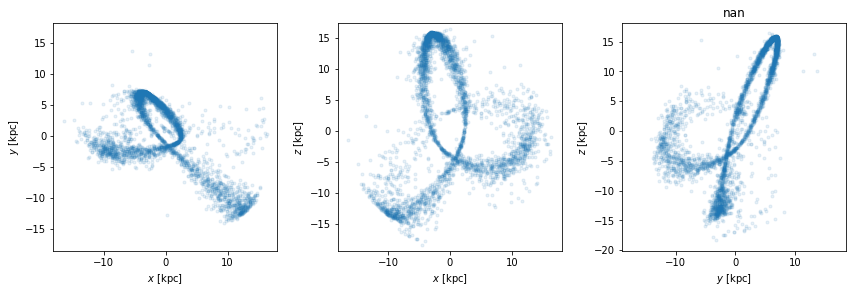

In [13]:
w = gd.PhaseSpacePosition.from_hdf5(f['streams/8483'])
_ = w.plot(alpha=0.1, marker='.')
plt.title(f['streams/8483/t_disrupt'].value)
print(f['streams/8483/t_disrupt'].value)

Text(0,0.5,'$dec$ [deg]')

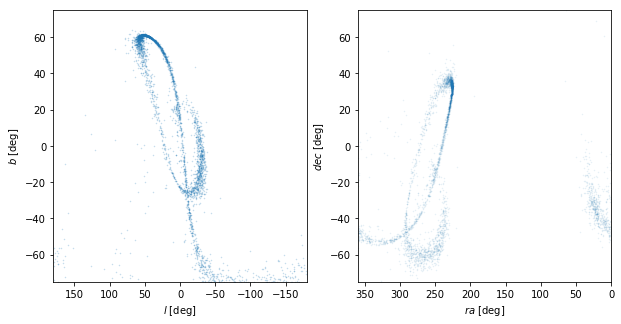

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
eq = w.to_coord_frame(coord.ICRS)
gal = w.to_coord_frame(coord.Galactic)
ax[0].plot(gal.l.wrap_at(180.*u.deg),gal.b.degree, marker='.', linestyle='none', alpha=0.25, markersize=1)
ax[1].plot(eq.ra.degree, eq.dec.degree, marker='.', linestyle='none', alpha=0.1, markersize=1)

ax[0].set_xlim(180, -180)
ax[0].set_ylim(-75, 75)

ax[1].set_xlim(360, 0)
ax[1].set_ylim(-75, 75)
ax[0].set_xlabel('$l$ [deg]')
ax[0].set_ylabel('$b$ [deg]')
ax[1].set_xlabel('$ra$ [deg]')
ax[1].set_ylabel('$dec$ [deg]')


(-10, 20)

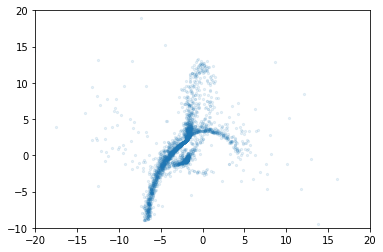

In [20]:
plt.scatter(gal.pm_l_cosb, gal.pm_b, s=5, alpha=0.1)
plt.xlim(-20, 20)
plt.ylim(-10, 20)

In [19]:
gal.l.wrap_at(180.*u.deg)

<Angle [ -23.44898098,-172.54069964, -26.75461828,...,   51.97478624,
          52.13741674,  51.93322413] deg>